In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import mpl
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing
from sklearn import svm 
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns',1000)
pd.set_option('max_row',300)
np.set_printoptions(threshold=np.inf)

In [2]:
df_demand_train = pd.read_csv('./data/demand_train.csv',parse_dates = ['date'])
df_order_train  = pd.read_csv('./data/order_train.csv')
df_demand_test = pd.read_csv('./data/demand_test.csv',parse_dates=['date'])
df_order_test  = pd.read_csv('./data/order_test.csv')
df_order_train['type'] = df_order_train['type'].map({'A1':1,'A2':2,'A3':3})
df_order_test['type'] = df_order_test['type'].map({'A1':1,'A2':2,'A3':3})

# Transform

In [3]:
df_demand_train['year'] = df_demand_train['date'].apply(lambda x:x.year)
df_demand_train['month'] = df_demand_train['date'].apply(lambda x:x.month)
df_demand_train['day'] = df_demand_train['date'].apply(lambda x:x.day)

df_demand_test['year'] = df_demand_test['date'].apply(lambda x:x.year)
df_demand_test['month'] = df_demand_test['date'].apply(lambda x:x.month)
df_demand_test['day'] = df_demand_test['date'].apply(lambda x:x.day)

In [4]:
promt_month=df_demand_train.groupby(['product_id','year','month'])['is_sale_day'].sum()
df_order_train['promts'] = promt_month.values
promt_month=df_demand_test.groupby(['product_id','year','month'])['is_sale_day'].sum()
df_order_test['promts'] = promt_month.values
# data.head(40)

In [5]:
sale_month=df_demand_train.groupby(['product_id','year','month'])['label'].sum()
df_order_train['label'] = sale_month.values
df_order_test['label'] = 0
# data.head(40)

In [6]:
# # 绘制前几类的销售量走势

# fig = plt.figure(figsize=(24,15),dpi=80)

# for i in range(1):
#     ax = fig.add_subplot(111+i)
#     ax2 = ax.twinx()
#     # ax.set_title('#catogory 2')
#     data = df_order_train[(df_order_train.product_id==(1070+i))]
#     y1 = data.label.values
#     y2 = data.order.values
#     # y3 = data.promts.values * 200
#     # ty = data.type.values[0]
#     x = (data.year.values - 2018) * 12 + data.month.values
#     ax.plot(x,y1,label='label',color='blue',linestyle='--')
#     ax.legend(loc=2,bbox_to_anchor=(0.02,0.965))
#     ax2.plot(x,y2,label='order',color='green',linestyle='-.')
#     ax2.legend(loc=2,bbox_to_anchor=(0.02,0.905))
#     # ax.plot(x,y3,label='train',color='black',linestyle='-.')
#     ax.set_xlabel('idx:{}'.format(1040+i))
# plt.show()

# make features

In [7]:
df_order_train_o = df_order_train.copy()
df_order_test_o = df_order_test.copy()

In [8]:
df_order_train.columns

Index(['product_id', 'type', 'year', 'month', 'order', 'start_stock',
       'end_stock', 'promts', 'label'],
      dtype='object')

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_regression,mutual_info_regression,r_regression


# X = X.dropna()
sel1 = SelectKBest(score_func=f_regression, k=8)
sel1.fit(df_order_train.drop('label',axis=1).fillna(0),df_order_train.label)
indices = sel1.get_support(True)

for idx in sorted(indices,key=lambda x:sel1.scores_[x],reverse=True):
    print('{} / {:.3f}'.format(df_order_train.columns[idx],sel1.scores_[idx]))

    """start_stock / 2445.855
end_stock / 2424.961
promts / 609.089
order / 431.871
year / 294.058
month / 128.937
type / 100.312
product_id / 67.623
    """

start_stock / 2445.855
end_stock / 2424.961
promts / 609.089
order / 431.871
year / 294.058
month / 128.937
type / 100.312
product_id / 67.623


In [10]:
df_order_train_copy = df_order_train.copy()
df_order_test_copy = df_order_test.copy()

df_order_train.start_stock.fillna(0,inplace=True)
df_order_test.start_stock.fillna(0,inplace=True)
df_order_train.end_stock.fillna(0,inplace=True)
df_order_test.end_stock.fillna(0,inplace=True)

df_order_train['product_id']=df_order_train['product_id'].apply(lambda x:int(str(x)[1:]))
df_order_train['year']=df_order_train['year'].apply(lambda x:x-2018)
df_order_train['month_from_begin']=(df_order_train['year'].values)*12 + df_order_train['month']
df_order_train['is_month2']=(df_order_train['month']==2).apply(lambda x:(-1 if x else 1))   
df_order_train['masked_order']=(df_order_train['order'].values * ((df_order_train['label'] != 0) | df_order_train['month'].isin([10,11,12,1,2,3])).apply(lambda x:(1.0 if x else 0.2)))
df_order_train['masked_order'] = df_order_train['masked_order'].astype(np.float64)
df_order_train['masked_promts']=(df_order_train['promts'].values * ((df_order_train['label'] != 0) | df_order_train['month'].isin([10,11,12,1,2,3])).apply(lambda x:(1.0 if x else 0.2)))
df_order_train['masked_promts'] = df_order_train['masked_promts'].astype(np.float64)
df_order_train['cumsum_sales'] = np.log(df_order_train.groupby('product_id')['label'].cumsum()+1)
df_order_train['stock_dif'] = df_order_train.end_stock.values - df_order_train.start_stock.values

df_order_test['product_id']=df_order_test['product_id'].apply(lambda x:int(str(x)[1:]))
df_order_test['year']=df_order_test['year'].apply(lambda x:x-2018)
df_order_test['month_from_begin']=(df_order_test['year'].values)*12 + df_order_test['month']
df_order_test['is_month2']=(df_order_test['month']==2).apply(lambda x:(-1 if x else 1))   
df_order_test['masked_order']=df_order_test['order'].values
df_order_test['masked_promts']=df_order_test['promts'].values
df_order_test['cumsum_sales'] = df_order_train[(df_order_train['year']==3) & (df_order_train.month.isin([10,11,12]))]['cumsum_sales']
df_order_test['stock_dif'] = df_order_test.end_stock.values - df_order_test.start_stock.values

In [11]:
df_order_train['date'] = pd.to_datetime([
    '{}-{:02d}-01'.format(
    2018+df_order_train.year[i],df_order_train.month[i]
    ) for i in range(len(df_order_train))
])
df_order_test['date'] = pd.to_datetime([
    '{}-{:02d}-01'.format(
    2018+df_order_test.year[i],df_order_test.month[i]
    ) for i in range(len(df_order_test))
])


In [12]:
df_data = pd.concat((df_order_train,df_order_test),axis=0)
for i in ['3','6','9','12']:
    data_before = df_data.groupby('product_id')[['label','promts','start_stock']].shift(int(i)).fillna(0.)
    df_data[['before{}_label'.format(i),'before{}_promts'.format(i),'before{}_stock'.format(i)]] = data_before
# 统计值
df_data['before_mean_label'] = (df_data.before3_label.values + df_data.before6_label.values + df_data.before9_label.values)/3
df_data['before_mean_promts'] = (df_data.before3_promts.values + df_data.before6_promts.values + df_data.before9_promts.values)/3
df_data['before_dif1_label'] = (df_data.before3_label.values - df_data.before6_label.values)
df_data['before_dif2_label'] = (df_data.before6_label.values - df_data.before9_label.values)
df_data['before_dif3_label'] = (df_data.before3_label.values - df_data.before9_label.values)

In [13]:
added_feat = [
    'before3_label', 'before3_promts', 'before3_stock', 'before6_label', 'before6_promts','before6_stock',
    'before9_label', 'before9_promts', 'before9_stock', 'before12_label', 'before12_promts','before_mean_label',
    'before_mean_promts', 'before_dif1_label', 'before_dif2_label','before_dif3_label',]
df_order_train[added_feat] = df_data[added_feat].iloc[:len(df_order_train),:]
df_order_test[added_feat] = df_data[added_feat].iloc[len(df_order_test):,:]

# Train

In [14]:
df_order_train.columns

Index(['product_id', 'type', 'year', 'month', 'order', 'start_stock',
       'end_stock', 'promts', 'label', 'month_from_begin', 'is_month2',
       'masked_order', 'masked_promts', 'cumsum_sales', 'stock_dif', 'date',
       'before3_label', 'before3_promts', 'before3_stock', 'before6_label',
       'before6_promts', 'before6_stock', 'before9_label', 'before9_promts',
       'before9_stock', 'before12_label', 'before12_promts',
       'before_mean_label', 'before_mean_promts', 'before_dif1_label',
       'before_dif2_label', 'before_dif3_label'],
      dtype='object')

In [15]:
feat_list = [
    'product_id', 
    'type', 
    'year', 
    'month', 
    'month_from_begin',
    # 'dayofmonth',
    'masked_order',
    'masked_promts', 
    # 'cumsum_sales',
    'start_stock',
    'end_stock',  
    'is_month2',
    'before3_label', 
    'before3_promts', 
    'before3_stock',
    'before6_label', 
    # 'before6_promts',
    # 'before6_stock',
    'before9_label', 
    # 'before9_promts',
    # 'before9_stock', 
    # 'before12_label', 
    # 'before12_promts',
    'before_mean_label',
    'before_mean_promts', 
    'before_dif1_label', 
    'before_dif2_label',
    # 'before_dif3_label'
    # 'label', 
]

In [16]:
df_train_X = df_order_train[(df_order_train.year.isin([1,2]))][feat_list]
df_train_y = df_order_train[(df_order_train.year.isin([1,2]))]['label']
df_test_X  = df_order_test[feat_list]

In [17]:
df_train_X.info(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 11 to 7287
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          5000 non-null   int64  
 1   type                5000 non-null   int64  
 2   year                5000 non-null   int64  
 3   month               5000 non-null   int64  
 4   month_from_begin    5000 non-null   int64  
 5   masked_order        5000 non-null   float64
 6   masked_promts       5000 non-null   float64
 7   start_stock         5000 non-null   float64
 8   end_stock           5000 non-null   float64
 9   is_month2           5000 non-null   int64  
 10  before3_label       5000 non-null   float64
 11  before3_promts      5000 non-null   float64
 12  before3_stock       5000 non-null   float64
 13  before6_label       5000 non-null   float64
 14  before9_label       5000 non-null   float64
 15  before_mean_label   5000 non-null   float64
 16  befor

In [18]:
print(len(df_train_X),len(df_test_X))

5000 627


In [19]:
K = 9
kf = KFold(K,shuffle=True,random_state=520,)

#poisson regression

lgb_params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'poisson',
    'bagging_fraction': 0.8,
    'bagging_freq':1,
    'num_leaves': 80,
    'colsample_bytree': 0.45,
    'min_data': 200,
    'min_hessian': 1,   
    'verbose': -1
}

best_params = {
'learning_rate':0.01,
'boosting_type':'gbdt',
'objective':'poisson',
'bagging_fraction':0.9612253421356249,
'bagging_freq':1,
'num_leaves':81,
'colsample_bytree':0.38620036584303763,
'min_data':181,
'min_hessian':0.14304955352116125,
'verbose':-1,
}

for _k,_v in best_params.items():
    lgb_params[_k]=_v

In [20]:
def evalerror(pred,df):
    label = df.get_label().copy()
    score = mean_squared_error(label,pred)*0.5
    return ('0.5 mse',np.sqrt(score),False)


In [21]:
train_preds_lgb = np.zeros(df_train_X.shape[0])
test_preds_lgb = np.zeros((df_test_X.shape[0],K))

for i,(train_idx,val_idx) in enumerate(kf.split(df_train_X)):
    print('\n 第{}次训练...'.format(i))
    train_feat1 = df_train_X.iloc[train_idx]
    train_feat2 = df_train_X.iloc[val_idx]
    train_target1 = df_train_y.iloc[train_idx]
    train_target2 = df_train_y.iloc[val_idx]

    print('lightgbm')
    lgb_train1 = lgb.Dataset(train_feat1.values,train_target1.values)
    lgb_train2 = lgb.Dataset(train_feat2.values,train_target2.values)

    gbm = lgb.train(
        lgb_params,
        lgb_train1,
        num_boost_round=20000,
        valid_sets=lgb_train2,
        verbose_eval=500,
        feval=evalerror,
        early_stopping_rounds=200    
    )
    train_preds_lgb[val_idx] += gbm.predict(train_feat2)
    test_preds_lgb[:,i] = gbm.predict(df_test_X)
    print('\n')


 第0次训练...
lightgbm
Training until validation scores don't improve for 200 rounds
[500]	valid_0's poisson: -21891.4	valid_0's 0.5 mse: 2635.67
[1000]	valid_0's poisson: -22135.3	valid_0's 0.5 mse: 2011.1
[1500]	valid_0's poisson: -22194.9	valid_0's 0.5 mse: 1809.89
[2000]	valid_0's poisson: -22213.3	valid_0's 0.5 mse: 1772.61
Early stopping, best iteration is:
[2225]	valid_0's poisson: -22217.9	valid_0's 0.5 mse: 1764.45



 第1次训练...
lightgbm
Training until validation scores don't improve for 200 rounds
[500]	valid_0's poisson: -18336.2	valid_0's 0.5 mse: 1830.3
[1000]	valid_0's poisson: -18524.8	valid_0's 0.5 mse: 1714.78
[1500]	valid_0's poisson: -18585.9	valid_0's 0.5 mse: 1548.45
[2000]	valid_0's poisson: -18606.6	valid_0's 0.5 mse: 1484.41
[2500]	valid_0's poisson: -18615.2	valid_0's 0.5 mse: 1458.93
[3000]	valid_0's poisson: -18618.5	valid_0's 0.5 mse: 1452.56
Early stopping, best iteration is:
[3257]	valid_0's poisson: -18620	valid_0's 0.5 mse: 1448.17



 第2次训练...
lightgbm
Trai

In [22]:
# xgb_params = {
#     'learning_rate': 0.1,
#     'booster': 'gbtree',
#     'objective': 'reg:squarederror',
#     'max_leaves': 80,
#     'colsample_bytree': 0.6,
#     'max_depth': 20,
#     'min_child_weight': 200,
#     'seed': 2333
# }

# def rmsle(pred: np.ndarray, dtrain: xgb.DMatrix):
#     ''' Root mean squared log error metric.'''
#     y = dtrain.get_label()
#     score = np.sqrt(mean_squared_error(y,pred)*0.5)
#     return '0.5mse', score
# # lightrbm 和 xboost 结合训练
# train_preds_xgb = np.zeros(df_train_X.shape[0])
# test_preds_xgb = np.zeros((df_test_X.shape[0],K))


# for i, (train_index, test_index) in enumerate(kf.split(df_train_X)):
#     print('\n')
#     print('第{}次训练...'.format(i))

#     train_feat1 = df_train_X.iloc[train_idx]
#     train_feat2 = df_train_X.iloc[val_idx]
#     train_target1 = df_train_y.iloc[train_idx]
#     train_target2 = df_train_y.iloc[val_idx]
    

#     print('xgboost')

#     xgb_train1 = xgb.DMatrix(train_feat1.values,label=train_target1.values)
#     xgb_train2 = xgb.DMatrix(train_feat2.values,label=train_target2.values)
#     evallist = [(xgb_train1, 'eval')]

    
#     gbm = xgb.train(xgb_params,
#                     xgb_train1,
#                     num_boost_round=20000,
#                     evals = evallist,
#                     verbose_eval=500,
#                     feval = rmsle,
#                     early_stopping_rounds = 200,
#                     )

   
#     train_preds_lgb[val_idx] += gbm.predict(xgb.DMatrix(train_feat2))
#     test_preds_lgb[:,i] = gbm.predict(xgb.DMatrix(df_test_X))
#     print('\n')
    

In [23]:
df_train = df_order_train[df_order_train.year.isin([1,2])].copy()
df_train['preds']=train_preds_lgb
df_train.drop(df_train[(df_train['product_id']==145)].index,inplace=True)
df_Acc = df_train[['year','month','product_id','label','preds']]

In [24]:
gt = df_train['label'].values
preds = df_Acc['preds'].values
acc = (1-np.abs(gt-preds)/(gt+1))
df_train['acc'] = acc
df_train.head()

,product_id,type,year,month,order,start_stock,end_stock,promts,label,month_from_begin,is_month2,masked_order,masked_promts,cumsum_sales,stock_dif,date,before3_label,before3_promts,before3_stock,before6_label,before6_promts,before6_stock,before9_label,before9_promts,before9_stock,before12_label,before12_promts,before_mean_label,before_mean_promts,before_dif1_label,before_dif2_label,before_dif3_label,preds,acc
11,1,1,1,1,7049.0,110.0,270.0,0,3469.0,13,1,7049.0,0.0,10.851664,160.0,2019-01-01,4509.0,0.0,88.0,4954.0,0.0,41.0,4186.0,0.0,91.0,0.0,0.0,4549.666667,0.000000,-445.0,768.0,323.0,3435.560123,0.990363
12,1,1,1,2,1101.0,270.0,234.0,7,986.0,14,-1,1101.0,7.0,10.870585,-36.0,2019-02-01,4840.0,0.0,89.0,5038.0,0.0,186.0,5412.0,0.0,110.0,517.0,0.0,5096.666667,0.000000,-198.0,-374.0,-572.0,1109.919417,0.874448
13,1,1,1,3,4611.0,234.0,151.0,31,3583.0,15,1,4611.0,31.0,10.936476,-83.0,2019-03-01,5113.0,0.0,128.0,4726.0,0.0,109.0,5665.0,0.0,47.0,3190.0,0.0,5168.000000,0.000000,387.0,-939.0,-552.0,3449.259672,0.962684
14,1,1,1,4,6769.0,151.0,96.0,30,4438.0,16,1,6769.0,30.0,11.012496,-55.0,2019-04-01,3469.0,0.0,110.0,4509.0,0.0,88.0,4954.0,0.0,41.0,4186.0,0.0,4310.666667,0.000000,-1040.0,-445.0,-1485.0,3951.971537,0.890509
15,1,1,1,5,9941.0,99.0,66.0,31,5932.0,17,1,9941.0,31.0,11.105844,-33.0,2019-05-01,986.0,7.0,270.0,4840.0,0.0,89.0,5038.0,0.0,186.0,5412.0,0.0,3621.333333,2.333333,-3854.0,-198.0,-4052.0,4619.582795,0.778794


In [25]:
gt = df_train.groupby(['year','month','product_id'])[['label']].mean().values
acc = df_train.groupby(['year','month','product_id'])[['acc']].mean().values

In [26]:
gt.shape,acc.shape
NUM_CLASS = 208
gt = gt.reshape((-1,NUM_CLASS))
acc = acc.reshape((-1,NUM_CLASS))
gt.shape,acc.shape
gt = gt / (gt.sum(axis=1,keepdims=True))
acc = (acc * gt).sum(axis=1)

In [27]:
A=df_train[(df_train.year==2) & (df_train.month==2)][['product_id','preds','acc','label','order']]
A.index = range(len(A))
B=df_train[(df_train.year==1) & (df_train.month==2)][['product_id','preds','acc','label','order']]
B.index=range(len(B))
C=df_order_test[(df_order_test.year==3) & (df_order_test.month==2)][['label','order']].iloc[:-1]
C.index=range(len(C))

In [28]:
feedback = {}
for i in range(len(B)):
    if (B.loc[i,'acc'] < 0.4 or A.loc[i,'acc'] < 0.4) and A.loc[i,'label'] !=0 :
        feedback[B.loc[i,'product_id']+1000] = (A.loc[i,'label']-A.loc[i,'preds']) / (A.loc[i,'preds'])

In [29]:
feedback2 = {}
for i in range(len(B)):
    if (B.loc[i,'acc'] < 0.6 or A.loc[i,'acc'] < 0.6) and A.loc[i,'label'] !=0 and ((B.loc[i,'product_id']+1000) not in feedback.keys()):
        feedback2[B.loc[i,'product_id']+1000] = (A.loc[i,'label']-A.loc[i,'preds']) / (A.loc[i,'preds'])

In [30]:
feedback3 = {}
for i in range(len(B)):
    if (B.loc[i,'acc'] < 0.6 or A.loc[i,'acc'] < 0.6) and (
    (B.loc[i,'product_id']+1000) not in feedback.keys()) and (
    (B.loc[i,'product_id']+1000) not in feedback2.keys()) and (
        B.loc[i,'label']!=0
    ):
        feedback3[B.loc[i,'product_id']+1000] = (B.loc[i,'label']-B.loc[i,'preds']) / (B.loc[i,'preds'])

In [31]:
feedback

{1002: -0.80042664442257,
 1012: -0.5400317625615036,
 1013: -0.43194385915179767,
 1023: 0.26688591551932106,
 1024: 0.03967968264255027,
 1027: 0.5632065710244841,
 1063: -0.5622449437667908,
 1065: 3.957447887569644,
 1066: 0.06462892572106912,
 1067: 0.5500521111685253,
 1068: -0.40816357274401577,
 1070: 0.0008593522051113486,
 1071: -0.5478362788864732,
 1072: -0.40759487068911193,
 1073: -0.606937712511523,
 1077: 0.7354264057583364,
 1078: 2.503278771618584,
 1165: -0.5962109384136215,
 1166: 0.1852906419780969,
 1173: -0.42084378597858085,
 1175: 4.591893331923681,
 1178: -0.543357413824258,
 1179: -0.13733046011392935,
 1185: 0.18971091747614557,
 1188: -0.2748547530144069,
 1189: -0.06261810290390843,
 1190: 0.7592090906024873,
 1191: -0.08741715463115127,
 1192: -0.08926256190583091,
 1193: 0.47720692561963357,
 1194: -0.25106116406516404,
 1195: 0.015584122642879346,
 1196: 0.2492639927252344,
 1201: -0.40161268079788526,
 1202: 0.3056216291634836,
 1203: -0.35384988421373

In [32]:
feedback2

{1001: -0.35103430530468643,
 1006: -0.3156047267645391,
 1007: -0.36730337079880804,
 1009: 0.8531502013142709,
 1016: 1.0755284110767191,
 1018: -0.3017108717873419,
 1020: -0.3696928329189844,
 1025: 0.08820066912740075,
 1163: -0.36546611129662687,
 1167: 0.07847286273403153,
 1169: 0.17469692915679613,
 1171: -0.24061855937051124,
 1182: 1.1965345906574554,
 1184: -0.187849110455806,
 1186: -0.17220329106528298,
 1210: -0.34605678441868004}

In [33]:
feedback3

{1008: -0.21426188326332787,
 1010: -0.7511362260575956,
 1011: -0.5640910547425406,
 1014: 1.557283184465166,
 1015: 0.46460453577442234,
 1021: -0.035517058731689824,
 1172: 0.432144200995369,
 1174: -0.06874573638143285,
 1176: 0.039011975765246225,
 1177: -0.12548198212780715,
 1197: -0.13030895189365724,
 1198: -0.18249499167926128,
 1199: -0.08377898618426559,
 1200: 0.9620545451513034}

In [34]:
cur = pd.concat(
    (A,B,C),
    axis=1
)
cur.head(20)

,product_id,preds,acc,label,order,product_id,preds,acc,label,order,label,order
0,1,329.755489,0.461602,214.0,2755.0,1,1109.919417,0.874448,986.0,1101.0,0,1128.0
1,2,631.346803,-2.979109,126.0,2755.0,2,2485.196049,-0.018016,1231.0,1101.0,0,1128.0
2,3,262.852265,0.853891,308.0,2755.0,3,1016.198127,0.897000,1133.0,1101.0,0,1128.0
3,4,488.660677,0.943470,518.0,2755.0,4,786.526911,0.813965,663.0,1101.0,0,1128.0
4,5,366.563777,0.886170,329.0,2755.0,5,730.507961,0.737407,991.0,1101.0,0,1128.0
5,6,298.073362,0.541106,204.0,2755.0,6,1115.029955,0.828930,952.0,1101.0,0,1128.0
6,7,336.654235,0.422176,213.0,2755.0,7,1063.824561,0.952437,1117.0,1101.0,0,1128.0
7,8,157.436682,-156.436682,0.0,2755.0,8,411.078441,0.728153,323.0,1101.0,0,1128.0
8,9,241.210885,0.540649,447.0,2755.0,9,711.367887,0.944785,753.0,1101.0,0,1128.0
9,10,43.828095,-42.828095,0.0,2755.0,10,409.862787,-1.988959,102.0,1101.0,0,1128.0


In [53]:
year,month = 2020, 1
mean_acc = []
for i in range(acc.shape[0]):
    print('{:02d} | {}-{:02d} acc: {:.4f}%'.format(i,year,month,100*acc[i]))
    if month % 12 == 0:
        month = 0
        year += 1
    month +=1
    mean_acc.append(100*acc[i])
print('mean_acc:{:.4f}%'.format(sum(mean_acc)/len(mean_acc)))

# mean_acc:73.4580%
# mean_acc:73.3399%
# mean_acc:75.1823% change min_data
# mean_acc:75.4829%
# mean_acc:70.2288% just use two year's data, have improve in some day
# mean_acc:75.2338% with masked order
# mean_acc:78.1897%


00 | 2020-01 acc: 73.8558%
01 | 2020-02 acc: 66.4905%
02 | 2020-03 acc: 77.9125%
03 | 2020-04 acc: 82.9915%
04 | 2020-05 acc: 75.6554%
05 | 2020-06 acc: 77.5580%
06 | 2020-07 acc: 81.0191%
07 | 2020-08 acc: 78.5711%
08 | 2020-09 acc: 85.4030%
09 | 2020-10 acc: 78.6084%
10 | 2020-11 acc: 76.5565%
11 | 2020-12 acc: 80.8161%
12 | 2021-01 acc: 80.3822%
13 | 2021-02 acc: 42.9978%
14 | 2021-03 acc: 80.0766%
15 | 2021-04 acc: 71.9218%
16 | 2021-05 acc: 70.6027%
17 | 2021-06 acc: 74.2393%
18 | 2021-07 acc: 81.1634%
19 | 2021-08 acc: 84.6961%
20 | 2021-09 acc: 83.3009%
21 | 2021-10 acc: 77.1091%
22 | 2021-11 acc: 78.8127%
23 | 2021-12 acc: 79.8962%
mean_acc:76.6932%


In [54]:
ans_X  = df_order_test.copy()
ans_X.product_id=ans_X.product_id.apply(lambda x:x+1000)
ans_X.year=ans_X.year.apply(lambda x:2021)
ans_X.label = test_preds_lgb.sum(axis=1)/K

In [55]:
df_ans = ans_X.groupby(['month','product_id'])['month','product_id','label'].mean()
df_ans.head()

month  product_id        label
month product_id                                
1     1001          1.0      1001.0  2429.032651
      1002          1.0      1002.0  8047.913861
      1003          1.0      1003.0  2463.091027
      1004          1.0      1004.0  8212.295177
      1005          1.0      1005.0  4485.725697

In [56]:
df_ans['month']=df_ans['month'].apply(lambda x:'2021-0{}'.format(int(x)))
df_ans['product_id']=df_ans['product_id'].apply(lambda x:int(x))
df_ans.to_csv('submit_2year_masked_v3.csv',index=False)
df_ans.head()

month  product_id        label
month product_id                                  
1     1001        2021-01        1001  2429.032651
      1002        2021-01        1002  8047.913861
      1003        2021-01        1003  2463.091027
      1004        2021-01        1004  8212.295177
      1005        2021-01        1005  4485.725697

In [57]:
lgb_params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'poisson',
    'bagging_fraction': 0.8,
    'bagging_freq':1,
    'num_leaves': 6,
    'colsample_bytree': 0.45,
    'min_data': 4,
    'min_hessian': 1,   
    'verbose': -1
}

feat_list2 = [
    'product_id', 
    'type', 
    'year', 
    'month', 
    'month_from_begin',
    # 'dayofmonth',
    'masked_order',
    # 'masked_promts', 
    'order',
    'promts',
    'start_stock',
    'end_stock',  
    'is_month2',
    # 'label', 
]

df_train_X = df_order_train[(df_order_train.year.isin([2]))][feat_list2]
df_train_y = df_order_train[(df_order_train.year.isin([2]))]['label']
df_test_X  = df_order_test[feat_list2]

In [58]:
# 这里使用第三年的数据在单独训练一个模型，考虑order和预测的百分比综合

train_preds_lgb2 = np.zeros(df_train_X.shape[0])
test_preds_lgb2 = np.zeros((df_test_X.shape[0],K))

for i,(train_idx,val_idx) in enumerate(kf.split(df_train_X)):
    print('\n 第{}次训练...'.format(i))
    train_feat1 = df_train_X.iloc[train_idx]
    train_feat2 = df_train_X.iloc[val_idx]
    train_target1 = df_train_y.iloc[train_idx]
    train_target2 = df_train_y.iloc[val_idx]

    print('lightgbm')
    lgb_train1 = lgb.Dataset(train_feat1.values,train_target1.values)
    lgb_train2 = lgb.Dataset(train_feat2.values,train_target2.values)

    gbm = lgb.train(
        lgb_params,
        lgb_train1,
        num_boost_round=10000,
        valid_sets=lgb_train2,
        verbose_eval=500,
        feval=evalerror,
        early_stopping_rounds=100    
    )
    train_preds_lgb2[val_idx] += gbm.predict(train_feat2)
    test_preds_lgb2[:,i] = gbm.predict(df_test_X)
    print('\n')


 第0次训练...
lightgbm
Training until validation scores don't improve for 100 rounds
[500]	valid_0's poisson: -31631.5	valid_0's 0.5 mse: 2635.9
[1000]	valid_0's poisson: -31846.4	valid_0's 0.5 mse: 2215
[1500]	valid_0's poisson: -31907.8	valid_0's 0.5 mse: 2006.13
[2000]	valid_0's poisson: -31947.2	valid_0's 0.5 mse: 1871.28
[2500]	valid_0's poisson: -31971.5	valid_0's 0.5 mse: 1786.2
[3000]	valid_0's poisson: -31988.8	valid_0's 0.5 mse: 1734.86
[3500]	valid_0's poisson: -32001.3	valid_0's 0.5 mse: 1708.63
[4000]	valid_0's poisson: -32013.7	valid_0's 0.5 mse: 1678.57
[4500]	valid_0's poisson: -32022.8	valid_0's 0.5 mse: 1661.98
Early stopping, best iteration is:
[4854]	valid_0's poisson: -32028.4	valid_0's 0.5 mse: 1648.62



 第1次训练...
lightgbm
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[391]	valid_0's poisson: -19487.5	valid_0's 0.5 mse: 1872.43



 第2次训练...
lightgbm
Training until validation scores don't improve for 100 rounds
[500]

In [65]:
df_train = df_train_X = df_order_train[(df_order_train.year.isin([2]))]
df_train['preds'] = train_preds_lgb2
df_train['acc'] = (1-np.abs(df_train.label.values-df_train.preds.values)/(df_train.label.values + 1e-6))
# df_train.drop(df_train[(df_train.product_id==145)].index,inplace=True)

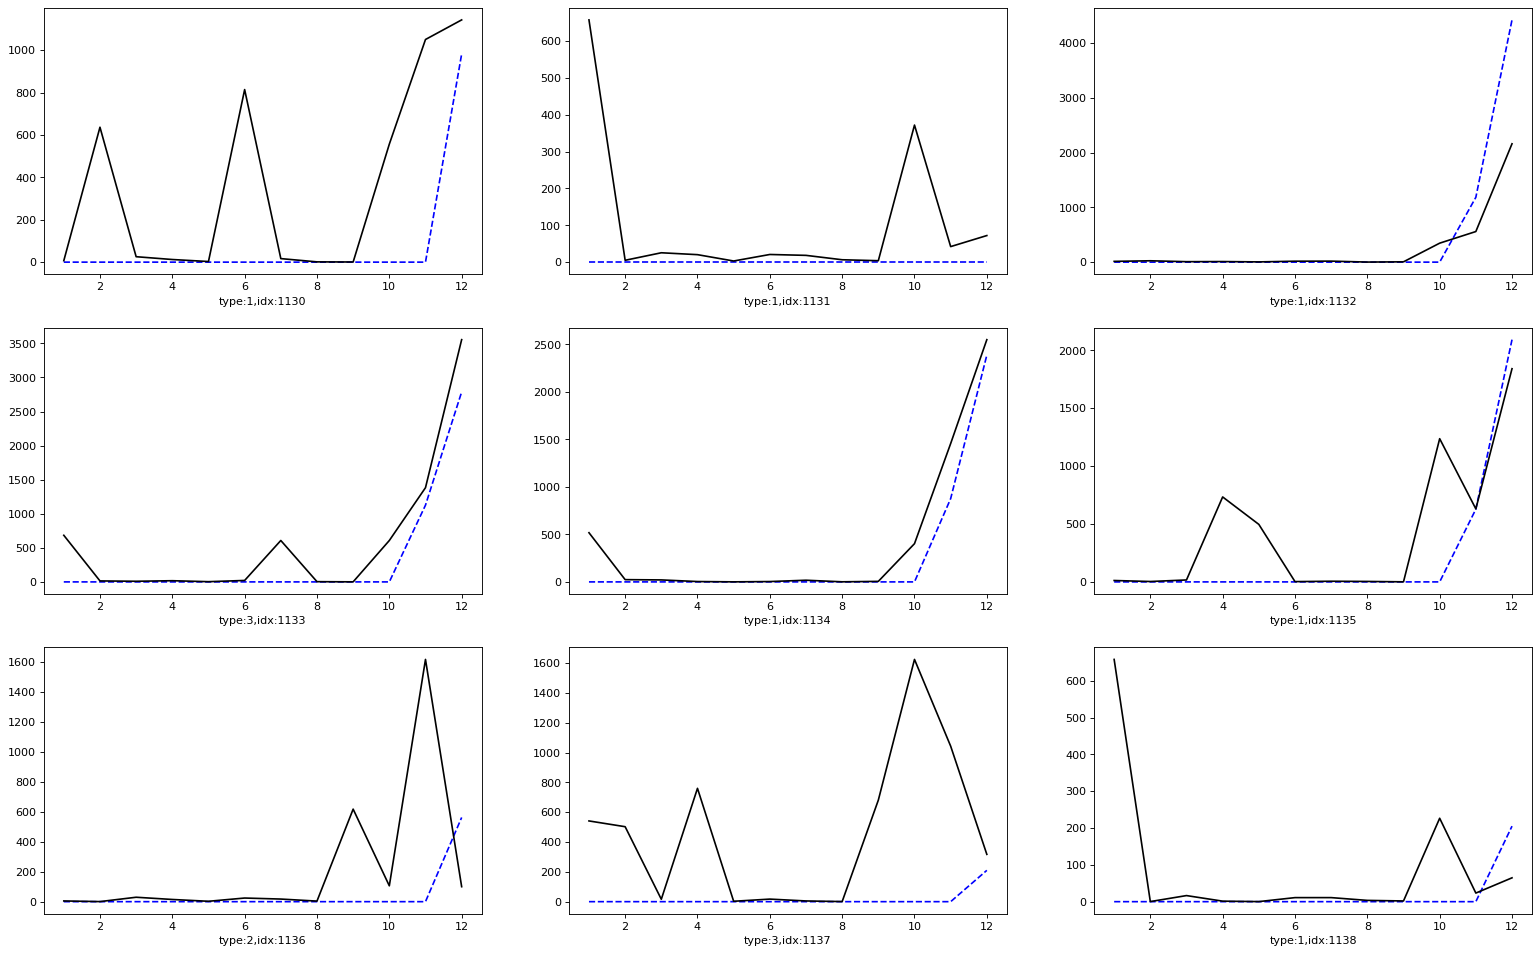

In [66]:
# 绘制前几类的销售量走势

fig = plt.figure(figsize=(24,15),dpi=80)

for i in range(9):
    ax = fig.add_subplot(331+i)
    # ax2 = ax.twinx()
    # ax.set_title('#catogory 2')
    data = df_train[(df_order_train.product_id==(130+i))]
    if data.empty:
        continue
    y1 = data.label.values
    # y2 = data.order.values
    y3 = data.preds.values
    # y3 = data.promts.values * 200
    ty = data.type.values[0]
    x = (data.year.values-2) * 12 + data.month.values
    ax.plot(x,y1,label='sales',color='blue',linestyle='--')
    ax.plot(x,y3,label='preds',color='black',linestyle='-')
    # ax2.plot(x,y2,label='order',color='green',linestyle='-.')
    # ax.plot(x,y3,label='train',color='black',linestyle='-.')
    ax.set_xlabel('type:{},idx:{}'.format(ty,1130+i))
plt.show()

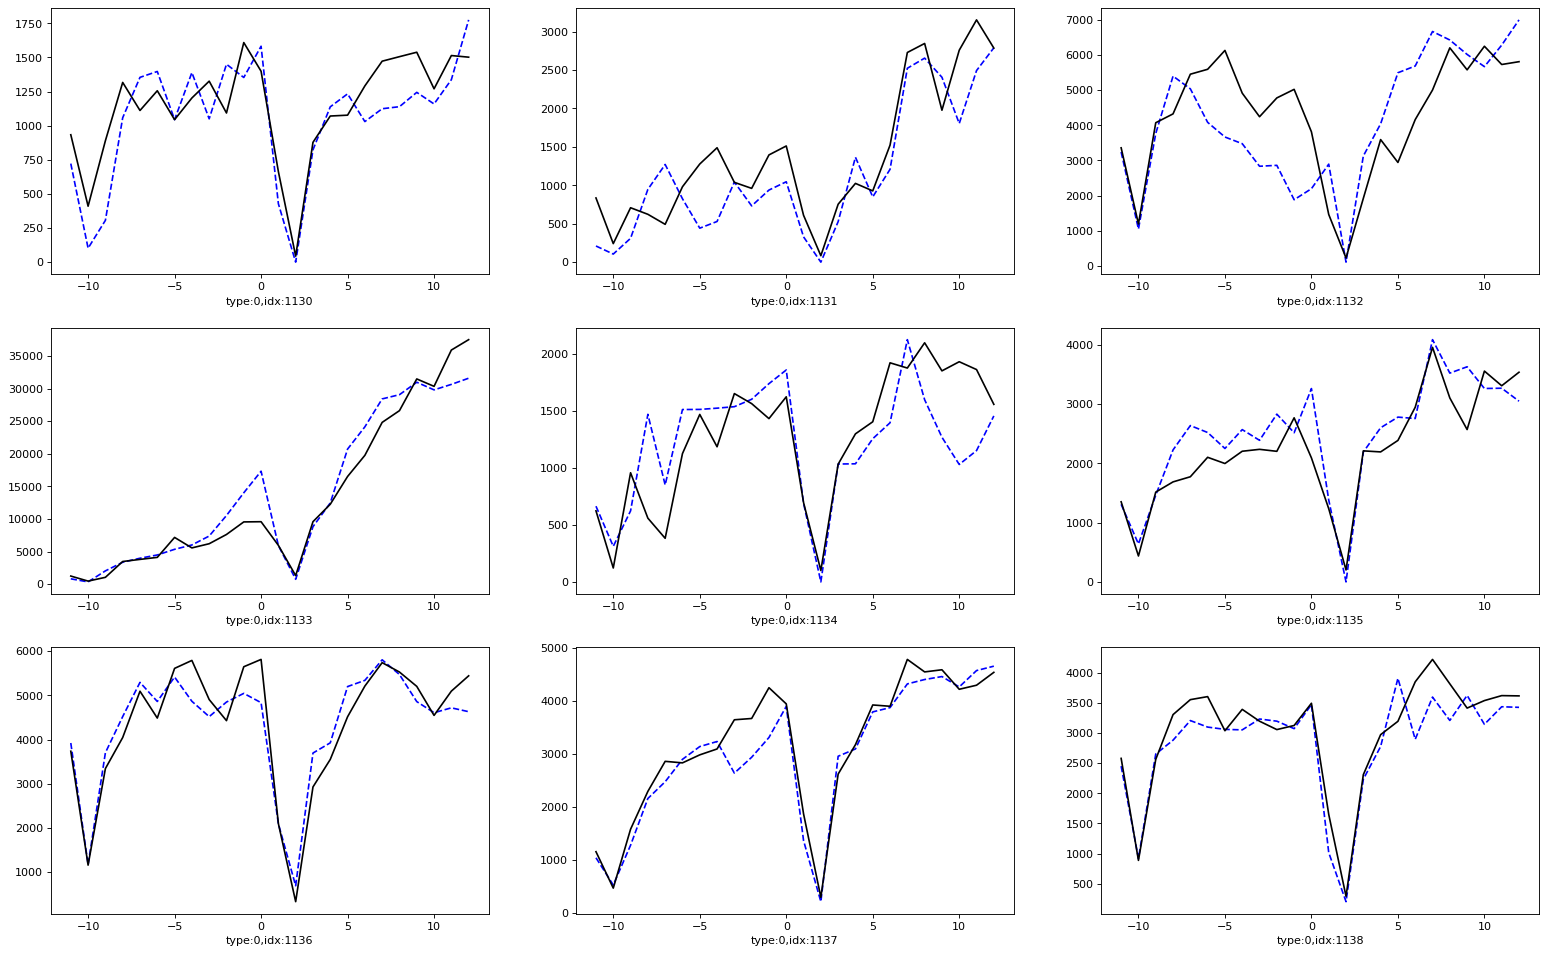

In [67]:
# 绘制前几类的销售量走势

fig = plt.figure(figsize=(24,15),dpi=80)

for i in range(9):
    ax = fig.add_subplot(331+i)
    # ax2 = ax.twinx()
    # ax.set_title('#catogory 2')
    data = df_Acc[(df_Acc.product_id==(10+i))]
    y1 = data.label.values
    # y2 = data.order.values
    y3 = data.preds.values
    # y3 = data.promts.values * 200
    ty = 0
    x = (data.year.values-2) * 12 + data.month.values
    ax.plot(x,y1,label='sales',color='blue',linestyle='--')
    ax.plot(x,y3,label='preds',color='black',linestyle='-')
    # ax2.plot(x,y2,label='order',color='green',linestyle='-.')
    # ax.plot(x,y3,label='train',color='black',linestyle='-.')
    ax.set_xlabel('type:{},idx:{}'.format(ty,1130+i))
plt.show()

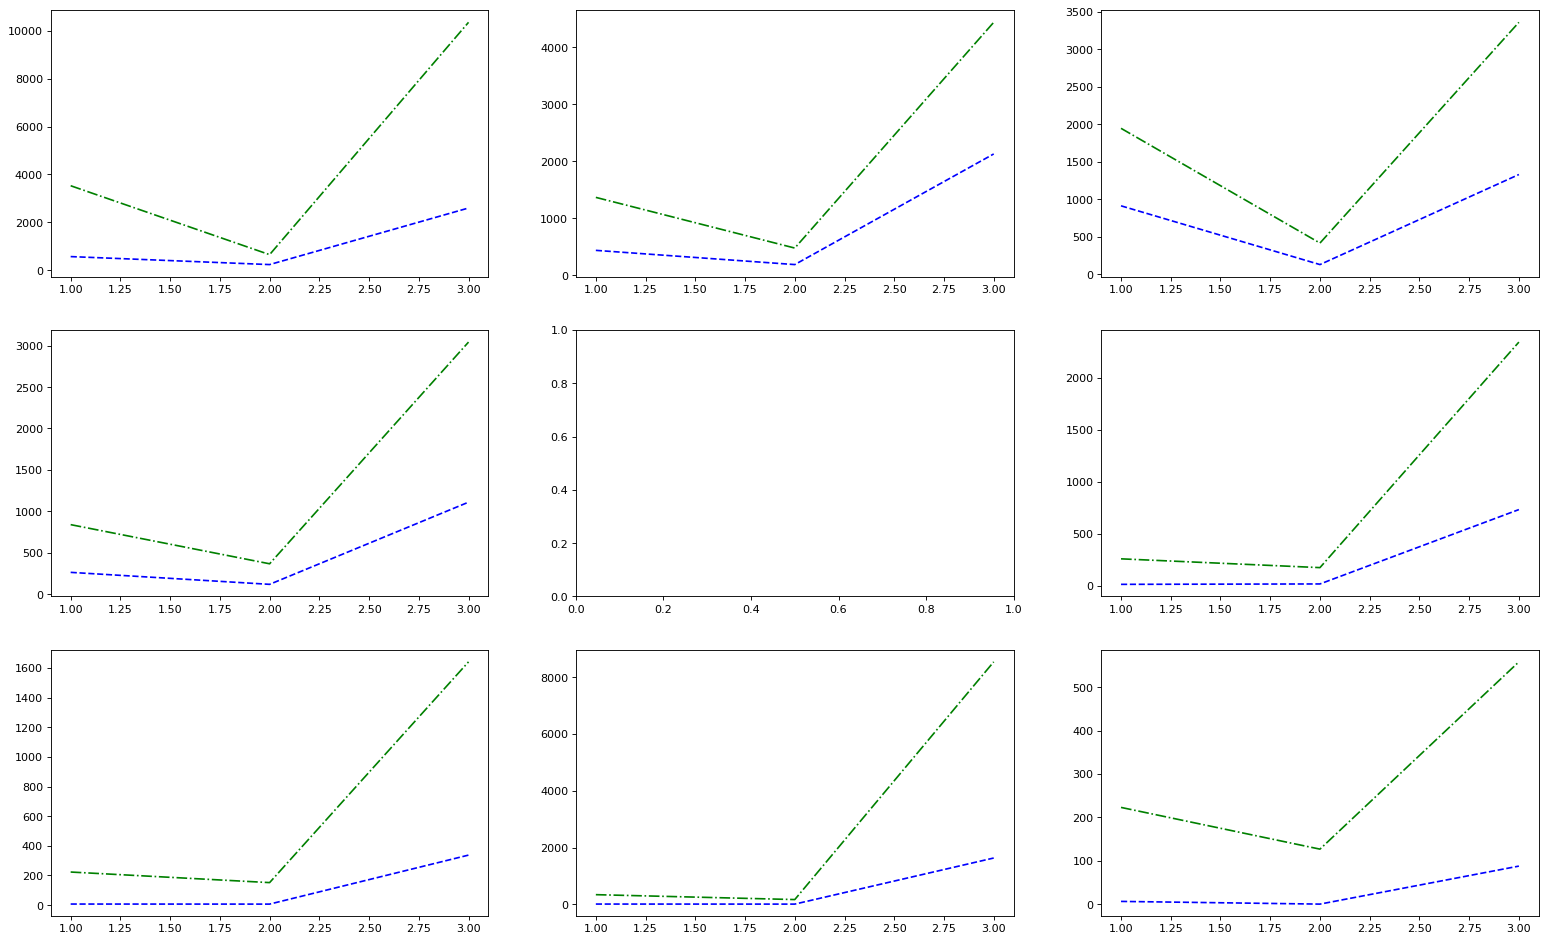

In [68]:
# 两种测试方法，在预测上的差异
ans_X1  = df_order_test.copy()
ans_X1.label = test_preds_lgb.sum(axis=1)/K

ans_X2  = df_order_test.copy()
ans_X2.label = test_preds_lgb2.sum(axis=1)/K
# 绘制前几类的销售量走势

fig = plt.figure(figsize=(24,15),dpi=80)

for i in range(9):
    ax = fig.add_subplot(331+i)
    # ax2 = ax.twinx()
    # ax.set_title('#catogory 2')
    data1 = ans_X1[(ans_X1.product_id==(140+i))]
    data2 = ans_X2[(ans_X2.product_id==(140+i))]
    if data1.empty:
        continue    
    y1 = data1.label.values
    y2 = data2.label.values
    x = [1,2,3]
    ax.plot(x,y1,label='sales_two',color='blue',linestyle='--')
    ax.plot(x,y2,label='sales_thr',color='green',linestyle='-.')
    # ax.set_xlabel('type:{},idx:{}'.format(ty,1040+i))
plt.show()

In [86]:
index = (df_order_train.groupby('product_id')['cumsum_sales'].max()<2)
index = [i for i in range(len(index)) if index.iloc[i]==True]
print(index)

[116, 130, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]


In [87]:
ans_X  = df_order_test.copy()

In [88]:
len(test_preds_lgb),len(test_preds_lgb2),len(ans_X)

(627, 627, 627)

In [89]:
preds = [
    (
        test_preds_lgb[i] * 0.52 + test_preds_lgb2[i] * 0.48
        if int(ans_X.iloc[i]['product_id']) in index 
        else test_preds_lgb[i]
    ) for i in range(len(ans_X))
]
preds = np.array(preds)

for i in range(len(ans_X)):
    if ans_X.iloc[i]['product_id'] in feedback.keys():
        preds[i] = preds[i] * (1+feedback[ans_X.iloc[i]['product_id']] * 0.12)

for i in range(len(ans_X)):
    if ans_X.iloc[i]['product_id'] in feedback2.keys():
        preds[i] = preds[i] * (1+feedback2[ans_X.iloc[i]['product_id']] * 0.12)   
        
for i in range(len(ans_X)):
    if ans_X.iloc[i]['product_id'] in feedback2.keys():
        preds[i] = preds[i] * (1+feedback2[ans_X.iloc[i]['product_id']] * 0.12)             

In [90]:
ans_X  = df_order_test.copy()
ans_X.product_id=ans_X.product_id.apply(lambda x:x+1000)
ans_X.year=ans_X.year.apply(lambda x:2021)
ans_X.label = preds

In [91]:
ans_X.head()

,product_id,type,year,month,order,start_stock,end_stock,promts,label,month_from_begin,is_month2,masked_order,masked_promts,cumsum_sales,stock_dif,date,before3_label,before3_promts,before3_stock,before6_label,before6_promts,before6_stock,before9_label,before9_promts,before9_stock,before12_label,before12_promts,before_mean_label,before_mean_promts,before_dif1_label,before_dif2_label,before_dif3_label
0,1001,1,2021,1,15182.0,117.0,165.0,31,2606.610057,37,1,15182.0,31,NaN,48.0,2021-01-01,3118.0,31.0,53.0,4025.0,31.0,106.0,2976.0,30.0,173.0,1636.0,31.0,3373.000000,30.666667,-907.0,1049.0,142.0
1,1001,1,2021,2,1128.0,165.0,151.0,28,599.523202,38,-1,1128.0,28,NaN,-14.0,2021-02-01,3364.0,30.0,52.0,3492.0,31.0,116.0,3701.0,31.0,63.0,214.0,29.0,3519.000000,30.666667,-128.0,-209.0,-337.0
2,1001,1,2021,3,10756.0,151.0,129.0,31,2878.770439,39,1,10756.0,31,NaN,-22.0,2021-03-01,3250.0,31.0,51.0,3213.0,30.0,73.0,3729.0,30.0,78.0,2555.0,31.0,3397.333333,30.333333,37.0,-516.0,-479.0
3,1002,2,2021,1,15182.0,213.0,869.0,0,9152.303228,37,1,15182.0,0,NaN,656.0,2021-01-01,9396.0,0.0,121.0,11252.0,0.0,94.0,6646.0,0.0,518.0,3376.0,0.0,9098.000000,0.000000,-1856.0,4606.0,2750.0
4,1002,2,2021,2,1128.0,869.0,676.0,0,1806.856057,38,-1,1128.0,0,NaN,-193.0,2021-02-01,10970.0,0.0,102.0,10267.0,0.0,75.0,8765.0,0.0,72.0,126.0,0.0,10000.666667,0.000000,703.0,1502.0,2205.0


In [92]:
df_ans = ans_X.groupby(['month','product_id'])['month','product_id','label'].mean()
df_ans.head()

month  product_id        label
month product_id                                
1     1001          1.0      1001.0  2606.610057
      1002          1.0      1002.0  9152.303228
      1003          1.0      1003.0  2729.113734
      1004          1.0      1004.0  9605.036927
      1005          1.0      1005.0  4717.855332

In [93]:
df_ans['month']=df_ans['month'].apply(lambda x:'2021-0{}'.format(int(x)))
df_ans['product_id']=df_ans['product_id'].apply(lambda x:int(x))
df_ans.to_csv('submit_2year_masked_v71.csv',index=False)
df_ans.head()

month  product_id        label
month product_id                                  
1     1001        2021-01        1001  2606.610057
      1002        2021-01        1002  9152.303228
      1003        2021-01        1003  2729.113734
      1004        2021-01        1004  9605.036927
      1005        2021-01        1005  4717.855332